# Project 1 - part A

Dataset with the 30 Stocks from S&P500 Index from 2014 to 2024

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("data.csv")
df_SP500 = pd.read_csv("data_sp500.csv")
df = df.dropna() # VRTX has null PX_LAST in 2015-05-12	
df_SP500.head()

,Date,PX Open,PX Last
0,2014-01-02,183.979996,182.919998
1,2014-01-03,183.229996,182.889999
2,2014-01-06,183.490005,182.360001
3,2014-01-07,183.089996,183.479996
4,2014-01-08,183.449997,183.520004


## Daily Return

In [101]:
tickers = df["Ticker"].unique()

def daily_return(df):
    if "Ticker" in df.columns:
        df["Daily_Return"] = df.groupby("Ticker")["PX_LAST"].pct_change()
        df.loc[df['Daily_Return'].isna(),"Daily_Return"] = 0
        return df

    df["Daily_Return"] = df["PX Last"].pct_change()
    df.loc[df['Daily_Return'].isna(),"Daily_Return"] = 0
    
    return df

df = daily_return(df)
df['Date'] = pd.to_datetime(df['Date'])
df_SP500 = daily_return(df_SP500)
df_SP500 = df_SP500[df_SP500["Date"]<="2023-31-31"]

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75479 entries, 0 to 75479
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          75479 non-null  datetime64[ns]
 1   PX_LAST       75479 non-null  float64       
 2   CUR_MKT_CAP   75479 non-null  float64       
 3   PX_VOLUME     75479 non-null  float64       
 4   Ticker        75479 non-null  object        
 5   Market_Value  75479 non-null  float64       
 6   Daily_Return  75479 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 4.6+ MB


## Value-Weighted and Equally-Weighted Portfolio

In [103]:
def equal_weight_daily_returns(df):
    """
        This function receives a time series with the daily return of n stocks. At the end it will return a times series with same length
        with the daily returns of a equal weighted portfolio. The portfolio is rebalanced with the cumulative value at the end of every month
    """
    
    # This is the value that we start with (100%)
    cumulative_value = 1

    # Number of Tickers
    n_tickers = len(df["Ticker"].unique())

    # Group by year and month
    grouped = df.groupby([df['Date'].dt.year, df['Date'].dt.month])

    # This is a list of dataframes grouped by the month and year of the Date column
    dfs_by_month_year = [group.reset_index(drop=True) for _, group in grouped]

    # Setting the base weight that will be multiplied by the cumulative_value
    equal_weight = 1 / n_tickers 

    EWP_Returs = []

    for i in range(len(dfs_by_month_year)):
        # For the value weight calculate all value_Weight, without rebalancing
        df_specific_month_year = dfs_by_month_year[i]
        df_specific_month_year["Equal_Weight"] = cumulative_value*equal_weight
        
        # Calculate the portfolio daily return
        df_specific_month_year["Equal_weight*Daily_Return"] = df_specific_month_year["Equal_Weight"]*df_specific_month_year["Daily_Return"]
        EWP_daily_returns = df_specific_month_year.groupby("Date")["Equal_weight*Daily_Return"].sum().rename("EWP_daily_return")
        
        # Update the cumulative return after this month
        for EWP_daily_return in EWP_daily_returns:
            cumulative_value*=(1+EWP_daily_return)
            
        EWP_Returs.append(EWP_daily_returns)
        
    return pd.concat(EWP_Returs)

In [104]:
def value_weight_daily_returns(df):
    """
        This function receives a time series with the daily return of n stocks. At the end it will return a times series with same length
        with the daily returns of a value weighted portfolio. The portfolio is rebalanced with the cumulative value at the end of every month
    """
    # This is the value that we start with (100%)
    cumulative_value = 1
    VWP_Returns = []
    # Group by year and month
    grouped = df.groupby([df['Date'].dt.year, df['Date'].dt.month])

    # This is a list of dataframes grouped by the month and year of the Date column
    dfs_by_month_year = [group.reset_index(drop=True) for _, group in grouped]

    for i in range(len(dfs_by_month_year)):
        # Get the value weight for all the stocks at the first day of the month
        df_specific_month_year = dfs_by_month_year[i]
        first_day = df_specific_month_year["Date"].min()
        total_MKT_CAP_first_day = df_specific_month_year[df_specific_month_year["Date"]==first_day]["CUR_MKT_CAP"].sum()
        value_weight_and_stock = df_specific_month_year.loc[df_specific_month_year["Date"]==first_day,["CUR_MKT_CAP","Ticker"]]
        value_weight_and_stock["Value_Weight"] =  value_weight_and_stock["CUR_MKT_CAP"] / total_MKT_CAP_first_day
        df_specific_month_year = pd.merge(df_specific_month_year, value_weight_and_stock, on='Ticker')
        # print(len(df_specific_month_year))
        df_specific_month_year["Value_Weight"] = cumulative_value*df_specific_month_year["Value_Weight"] # Rebalanced with the capital in the last day of previous month
        df_specific_month_year["Value_Weight*Daily_Return"] = df_specific_month_year["Value_Weight"]*df_specific_month_year["Daily_Return"]
        VWP_daily_returns = df_specific_month_year.groupby("Date")["Value_Weight*Daily_Return"].sum().rename("VWP_daily_return")

        for VWP_daily_return in VWP_daily_returns:
            cumulative_value*=(1+VWP_daily_return)
            
        VWP_Returns.append(VWP_daily_returns)
        
    return pd.concat(VWP_Returns)

In [105]:
# Connecting all the dataframes

# This dataframe contains the daily return of both portfolios
portfolios = pd.DataFrame({
    "Daily_Return_with_Equal_Weighted_Portfolio": equal_weight_daily_returns(df.copy()),
    "Daily_Return_with_Value_Weighted_Portfolio": value_weight_daily_returns(df.copy())
})

portfolios.reset_index(inplace=True)
# print(equal_weight_daily_returns(df))

## Annualized Average Return of both porfolios and S&P 500

In [106]:
# Compute annualized average return
annualized_df = portfolios.groupby(portfolios['Date'].dt.strftime('%Y'))[["Daily_Return_with_Equal_Weighted_Portfolio","Daily_Return_with_Value_Weighted_Portfolio"]].mean()*252
annualized_df.reset_index(inplace=True)
annualized_df.rename(columns={"Daily_Return_with_Equal_Weighted_Portfolio":"Average_Annual_Return_with_Equal_Weighted_Portfolio","Daily_Return_with_Value_Weighted_Portfolio":"Average_Annual_Return_with_Value_Weighted_Portfolio"},inplace=True)
annualized_dfSP500 = (df_SP500.groupby(portfolios['Date'].dt.strftime('%Y'))["Daily_Return"].mean()*252).to_list()
annualized_df["Average_Annual_Return_with_SP500_Portfolio"] = annualized_dfSP500

In [107]:
annualized_df

,Date,Average_Annual_Return_with_Equal_Weighted_Portfolio,Average_Annual_Return_with_Value_Weighted_Portfolio,Average_Annual_Return_with_SP500_Portfolio
0,2014,0.239542,0.107372,0.122920
1,2015,0.014034,0.141717,0.003946
2,2016,0.249644,0.119752,0.100687
3,2017,0.334828,0.334420,0.180231
4,2018,-0.124841,-0.086713,-0.051167
5,2019,0.552997,0.493617,0.260965
6,2020,-0.034457,0.207112,0.205756
7,2021,0.955253,1.173304,0.247972
8,2022,-0.279740,-1.037498,-0.188107
9,2023,0.573372,0.584885,0.227913


## Annualized Standard Deviation

In [108]:
# compute annualized standard deviation return
standard_deviation_return = portfolios.groupby(portfolios['Date'].dt.strftime('%Y'))[["Daily_Return_with_Equal_Weighted_Portfolio","Daily_Return_with_Value_Weighted_Portfolio"]].std(ddof=0) * np.sqrt(252)
standard_deviation_return.reset_index(inplace=True)
standard_deviation_return = standard_deviation_return.rename(columns={"Daily_Return_with_Equal_Weighted_Portfolio":"Standard_Deviation_with_Equal_Weighted_Portfolio","Daily_Return_with_Value_Weighted_Portfolio":"Standard_Deviation_with_Value_Weighted_Portfolio"})
standard_deviation_return_SP500 = (df_SP500.groupby(portfolios['Date'].dt.strftime('%Y'))["Daily_Return"].std(ddof=0)*np.sqrt(252)).to_list()
standard_deviation_return["Standard_Deviation_with_SP500_Portfolio"] = standard_deviation_return_SP500

In [109]:
standard_deviation_return

,Date,Standard_Deviation_with_Equal_Weighted_Portfolio,Standard_Deviation_with_Value_Weighted_Portfolio,Standard_Deviation_with_SP500_Portfolio
0,2014,0.151781,0.148894,0.112173
1,2015,0.215832,0.209351,0.155441
2,2016,0.221749,0.188618,0.131082
3,2017,0.149834,0.136968,0.067574
4,2018,0.407061,0.407541,0.170989
5,2019,0.321539,0.300041,0.125255
6,2020,0.789416,0.708496,0.334469
7,2021,0.496037,0.750200,0.130795
8,2022,0.846607,0.810398,0.242203
9,2023,0.421825,0.343680,0.131624


In [110]:
# CHANGE THIS VALUE FOR A REAL VALUE
risk_free_annual_rate = 0.0559
risk_free_daily = ((risk_free_annual_rate + 1)/1)**(1/365)-1

portfolios["risk_free_daily_return"] = risk_free_daily

## Sharpe Ratio and Information Ratio with annualized Average Return

In [111]:
annualized_df["Excess_Return_EWP"] = annualized_df["Average_Annual_Return_with_Equal_Weighted_Portfolio"] - risk_free_annual_rate
risk_premium_EWP = annualized_df["Excess_Return_EWP"].mean()
SD_Excess_Return_EWP = annualized_df["Excess_Return_EWP"].std(ddof=0)
sharpe_ratio_EWP = risk_premium_EWP / SD_Excess_Return_EWP
print(sharpe_ratio_EWP)

0.5416268840455255


## Plot cumulative returns for both porfolios, S&P 500 and risk-free using daily returns

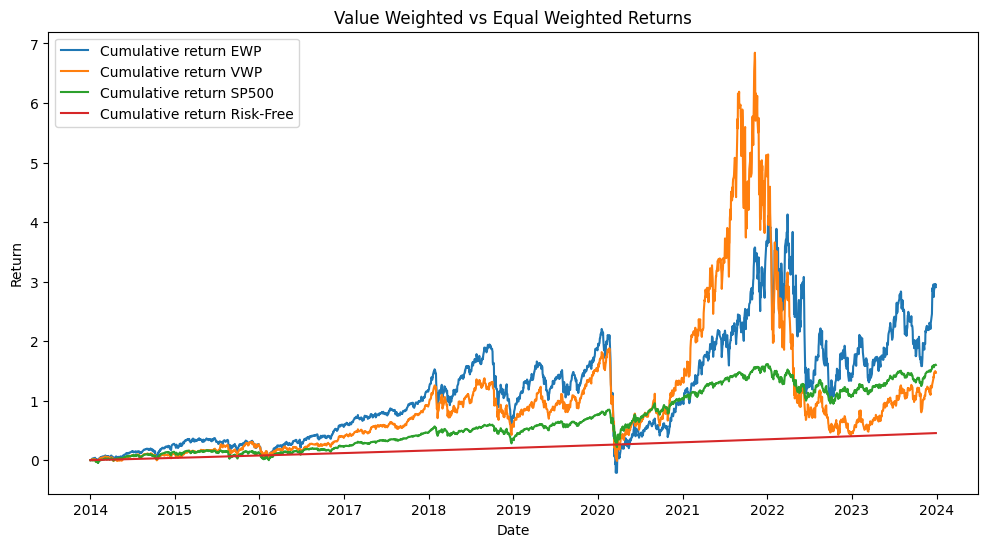

In [112]:
cumulative_returns_EWP = (portfolios["Daily_Return_with_Equal_Weighted_Portfolio"]+1).cumprod() - 1
cumulative_returns_VWP = (portfolios["Daily_Return_with_Value_Weighted_Portfolio"]+1).cumprod() - 1
cumulative_returns_RiskFree = (portfolios["risk_free_daily_return"]+1).cumprod() - 1
cumulative_returns_SP500 = (df_SP500["Daily_Return"]+1).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(portfolios["Date"], cumulative_returns_EWP, label="Cumulative return EWP")
plt.plot(portfolios["Date"], cumulative_returns_VWP, label="Cumulative return VWP")
plt.plot(portfolios["Date"], cumulative_returns_SP500, label="Cumulative return SP500")
plt.plot(portfolios["Date"], cumulative_returns_RiskFree, label="Cumulative return Risk-Free")

plt.title(f"Value Weighted vs Equal Weighted Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()

In [113]:
# This is to use in part B (I think)
# Expected post Returns
ex_post_return = annualized_df["Average_Annual_Return_with_Equal_Weighted_Portfolio"].mean()
print(portfolios["Daily_Return_with_Equal_Weighted_Portfolio"].mean()*252)
# risk = returns_per_year["Annually_Return_EWP"].std()
print(ex_post_return)
# print(risk)

0.24801592937805716
0.2480633041767942


## Part B

In [143]:
import random

tickers = df['Ticker'].unique()
n = random.randint(1, len(tickers))

random_tickers = random.sample(list(tickers),n)

print(random_tickers)

['BK', 'JPM', 'SMCI']


In [200]:
def compute_ex_post_return_and_variance(df: pd.DataFrame,tickers: list):
    selected_data = df[df['Ticker'].isin(tickers)].copy()
    portfolio_daily_returns = equal_weight_daily_returns(selected_data)
    ex_post_return = portfolio_daily_returns.mean()
    variance = portfolio_daily_returns.var()
    # For some reason the variance sometimes is alomost infinite
    if variance>1e10:
        variance = 0
    return ex_post_return,variance

ex_return,variance = compute_ex_post_return_and_variance(df,random_tickers)

In [201]:
# Repeat the process 10 times
def simulate_portfolio_variances(df: pd.DataFrame, n: int, repetitions: int = 10) -> list:
    portfolio_variances = []
    for _ in range(repetitions):
        random_tickers = random.sample(list(tickers), n)
        ex_return,variance = compute_ex_post_return_and_variance(df, random_tickers)
        portfolio_variances.append(variance)
    return portfolio_variances

In [202]:
simulate_portfolio_variances(df,n)

[0.0008033874690611495,
 0.00037991184524388197,
 0.0007346942616290453,
 0.0006834463548110482,
 0.007460456579450483,
 0.002683335399801358,
 0.0011422413240800774,
 0.0010885028684653746,
 0,
 0.0004992325628844901]

In [203]:
# Repeat for n = 1, 2, ..., 30
def simulate_variances_accross_portfolio_sizes(df: pd.DataFrame, max_n: int, repetitions: int = 10) -> pd.DataFrame:
    all_variances = {}
    
    for n in range(1, max_n + 1):
        variances = simulate_portfolio_variances(df, n, repetitions)
        all_variances[n] = variances
        
    return all_variances

In [204]:
all_variances = simulate_variances_accross_portfolio_sizes(df, 30)
pd.DataFrame(all_variances)

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0.000472,0.000894,0.003200,0.000863,0.001455,0.001162,0.001068,0.001134,0.001043,0.001215,...,0.001042,0.000755,0.000808,0.001091,0.000586,0.000807,0.000890,0.000930,0.000877,0.000865
1,0.000456,0.000507,0.000388,0.000567,0.000549,0.001063,0.000600,0.000562,0.000532,0.001117,...,0.000870,0.000707,0.000751,0.000781,0.001008,0.001064,0.000927,0.000847,0.000923,0.000865
2,0.000223,0.000000,0.000616,0.000795,0.000907,0.001303,0.000675,0.000698,0.000465,0.000861,...,0.000906,0.000854,0.000968,0.000875,0.001060,0.000909,0.000637,0.000774,0.000839,0.000865
3,0.000630,0.000492,0.006102,0.000427,0.000371,0.000847,0.000351,0.001121,0.000902,0.000453,...,0.000929,0.000730,0.001072,0.000627,0.000825,0.000811,0.000868,0.000837,0.000910,0.000865
4,0.000845,0.003675,0.000451,0.001148,0.000679,0.000410,0.000538,0.000719,0.001281,0.000857,...,0.000722,0.000827,0.000984,0.000906,0.001066,0.000900,0.000908,0.000900,0.000887,0.000865
5,0.000472,0.008477,0.000563,0.002170,0.000387,0.000479,0.001235,0.000790,0.001878,0.000858,...,0.000894,0.000847,0.000925,0.000946,0.000995,0.000880,0.000879,0.000891,0.000943,0.000865
6,0.000992,0.000803,0.000253,0.000973,0.000603,0.000651,0.001037,0.001167,0.000561,0.000675,...,0.000914,0.000891,0.000856,0.000745,0.001066,0.000718,0.000974,0.000847,0.000830,0.000865
7,0.000263,0.000289,0.000333,0.000379,0.000439,0.001430,0.001632,0.000651,0.001088,0.000472,...,0.001083,0.000605,0.000731,0.000820,0.000995,0.000978,0.000949,0.000895,0.000887,0.000865
8,0.000456,0.001153,0.000546,0.000667,0.001556,0.000398,0.000544,0.001229,0.001665,0.000365,...,0.000962,0.000780,0.000916,0.001041,0.000727,0.000976,0.000866,0.000822,0.000889,0.000865
9,0.000696,0.000567,0.000592,0.001626,0.000646,0.004246,0.000743,0.001456,0.000963,0.000425,...,0.000739,0.000963,0.000939,0.001022,0.000797,0.000861,0.000743,0.000940,0.000783,0.000865


In [205]:
x = []
y = []

for key, values in all_variances.items():
    x.extend([key] * len(values))
    y.extend(values)

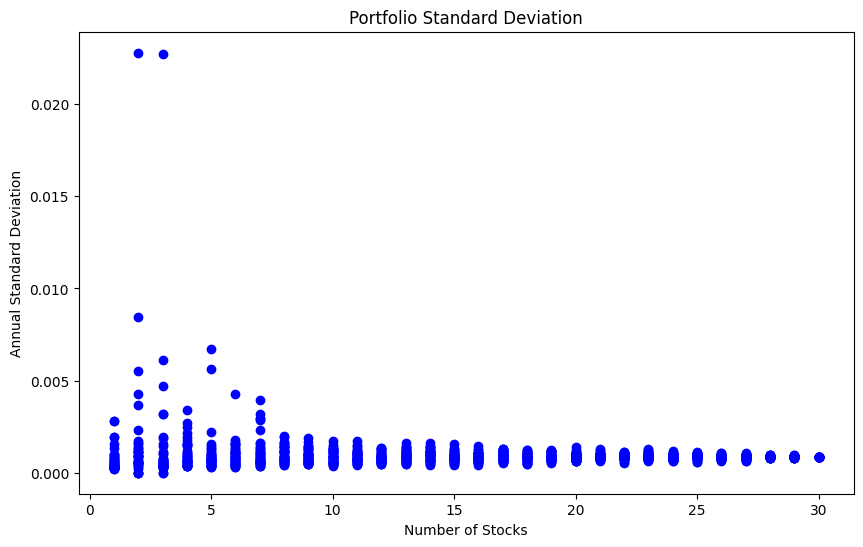

In [206]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue')

plt.xlabel('Number of Stocks')
plt.ylabel('Annual Standard Deviation')
plt.title('Portfolio Standard Deviation')


plt.show()